# Lecture 26 - Bayesian Model Selection

## Objectives

+ Compute the model evidence.
+ Compare models using Bayes factors.
+ ...

In [46]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])

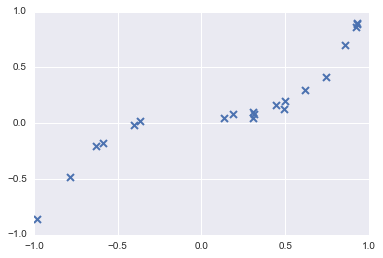

In [181]:
np.random.seed(12345)
num_samples = 20
sigma = 0.1
X = 2 * np.random.rand(num_samples) - 1.
X = X[:, None]
Y = X ** 3 + sigma * np.random.rand(num_samples, 1)
plt.plot(X, Y, 'x', markeredgewidth=2)

30.868407449


/Users/ibilion/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


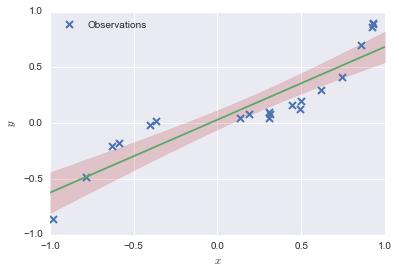

In [186]:
from sklearn.linear_model import BayesianRidge

degree = 1
phi = PolynomialBasis(degree)
Phi = compute_design_matrix(X, phi)
model = BayesianRidge()
model.fit(X, Y)

X_p = np.linspace(-1, 1, 100)[:, None]
# They are using different names:
#sigma = 0.5
#alpha = 0.01
sigma = np.sqrt(1. / model.alpha_)
#print 'best sigma:', sigma
alpha = model.lambda_
#print 'best alpha:', alpha
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p)[:, None] # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(X_p, Y_p)
ax.fill_between(X_p.flatten(), Y_l_ep.flatten(), Y_u_ep.flatten(), color=sns.color_palette()[2], alpha=0.25)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best')

# Log likelihood
num_param = phi.num_basis
num_samples = X.shape[0]
def log_like(theta):
    alpha = theta[0]
    sigma = theta[1]
    return 0.5 * num_param * np.log(alpha) - num_samples * np.log(sigma) \
               -0.5 * np.linalg.norm((Y.flatten() - np.dot(Phi, m))) ** 2 / sigma ** 2\
               -0.5 * alpha * np.dot(m.flatten(), m.flatten()) \
               - 0.5 * np.log(np.linalg.det(A)) \
               -0.5 * num_samples * np.log(2. * np.pi)
bic = -num_samples * np.log(sigma) - 0.5 * num_param * np.log(num_samples)
print bic

TypeError: can only concatenate list (not "float") to list

In [131]:
help(scipy.diff)

Help on function diff in module numpy.lib.function_base:

diff(a, n=1, axis=-1)
    Calculate the n-th order discrete difference along given axis.
    
    The first order difference is given by ``out[n] = a[n+1] - a[n]`` along
    the given axis, higher order differences are calculated by using `diff`
    recursively.
    
    Parameters
    ----------
    a : array_like
        Input array
    n : int, optional
        The number of times values are differenced.
    axis : int, optional
        The axis along which the difference is taken, default is the last axis.
    
    Returns
    -------
    diff : ndarray
        The `n` order differences. The shape of the output is the same as `a`
        except along `axis` where the dimension is smaller by `n`.
    
    See Also
    --------
    gradient, ediff1d, cumsum
    
    Examples
    --------
    >>> x = np.array([1, 2, 4, 7, 0])
    >>> np.diff(x)
    array([ 1,  2,  3, -7])
    >>> np.diff(x, n=2)
    array([  1,   1, -10])
    
